## Parsing and Processing Kraken Results

### Identify the target species and potential contaminants from the taxonomic classification from Kraken output

In [137]:
import pandas as pd
import sys

# Read command-line arguments
#fasta_file = sys.argv[[1]]
#kraken_file = sys.argv[2]
#phyloligo_file = sys.argv[3]
#output_file = sys.argv[4]

def parse_kraken_output(file_path):
    sequence_taxid_mapping = {}
    table_data = []

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith("C") or line.startswith("U"):
                parts = line.strip().split('\t')
                sequence_id = parts[1]
                tax_id = parts[2]
                sequence_taxid_mapping[sequence_id] = tax_id
            else:
                # Assuming this line is part of the table
                table_data.append(line.strip().split('\t'))

    # Remove header row if it exists in table_data
    if table_data[0][0] == '%':
        table_data.pop(0)

    # Converting table data to DataFrame
    columns = ['%', 'reads', 'taxReads', 'kmers', 'dup', 'cov', 'taxID', 'rank', 'taxName']
    df = pd.DataFrame(table_data, columns=columns)
    return sequence_taxid_mapping, df

#COMMENT OUT
kraken_file = 'ecoli_10_tb_3_kraken.txt'
#######

sequence_taxid_mapping, kraken_df = parse_kraken_output(kraken_file)

#pre-processing: filling values of rank
kraken_df.loc[(kraken_df['rank'] == 'no rank') & kraken_df['taxName'].str.contains('str'),'rank'] = 'strain'
kraken_df.loc[(kraken_df['rank'] == 'no rank') & kraken_df['taxName'].str.contains('group'),'rank'] = 'kingdom'

kraken_df["cov"] = pd.to_numeric(kraken_df["cov"])

In [138]:
# Sort the DataFrame by rank specificity and coverage
rank_order = ['domain','superkingdom', 'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species group','species', 'strain', 'no rank']
rank_index = {rank: index for index, rank in enumerate(rank_order)}
kraken_df['rank_index'] = kraken_df['rank'].map(rank_index)

df_sorted = kraken_df.sort_values(by=['rank_index', 'cov'], ascending=[True, False])

In [139]:
#Filtering df to lowest ranks (max rank_index values to identify contaminants)
df_filtered = kraken_df[kraken_df['rank_index'] >= 8]

# Identify the target species based on the highest coverage
target_row = df_filtered.sort_values(by='cov', ascending=False).iloc[0]

target_species_name = target_row['taxName']
target_species_id = target_row['taxID']

kraken_contaminants_dict = []
kraken_contaminants = []

# Iterate through the lowest rank dataframe
for index, row in df_filtered.iterrows():
    if row['taxName'] != target_species_name:
        # For each potential contaminant, find the corresponding sequence IDs
        sequence_ids = [seq_id for seq_id, tax_id in sequence_taxid_mapping.items() if str(tax_id) == str(row['taxID'])]
        # Append the contaminant details to the list
        kraken_contaminants_dict.append({'taxName': row['taxName'], 'taxID': row['taxID'], 'sequence_IDs': sequence_ids})
        kraken_contaminants.extend(sequence_ids)
        
# Output the list of contaminants
print(kraken_contaminants)

['tb_sequence_1', 'tb_sequence_2', 'tb_sequence_3']


## Exploring Custom built Database-free Approaches

### GC content, simple k-mer profiling + clustering

In [140]:
def calculate_gc_content(sequence):
    gc_count = sum(1 for base in sequence if base in ["G", "C"])
    return gc_count / len(sequence) * 100

def parse_fasta(filename):
    with open(filename, 'r') as file:
        sequences = {}
        sequence_ids = []
        current_seq = ''
        current_id = ''
        for line in file:
            line = line.strip()
            if line.startswith('>'):
                if current_id:
                    sequences[current_id] = current_seq
                    sequence_ids.append(current_id)
                current_id = line[1:]
                current_seq = ''
            else:
                current_seq += line
        if current_id:
            sequences[current_id] = current_seq
            sequence_ids.append(current_id)
        return sequences, sequence_ids

#COMMENT OUT
fasta_file = 'ecoli_10_tb_3.fasta'
#############

sequences, sequence_ids = parse_fasta(fasta_file)
print(sequence_ids)

gc_contents = {seq_id: calculate_gc_content(seq) for seq_id, seq in sequences.items()}

def calculate_deviation(gc_content, typical_range):
    if gc_content < typical_range[0]:
        return typical_range[0] - gc_content
    elif gc_content > typical_range[1]:
        return gc_content - typical_range[1]
    else:
        return 0

# Identify sequences with atypical GC content and their deviation
typical_gc_range = (40, 60)  # Adjustable range: currently set to e.coli (prokaryotic) range
atypical_gc_data = [(seq_id, calculate_deviation(gc, typical_gc_range)) 
                    for seq_id, gc in gc_contents.items() 
                    if not (typical_gc_range[0] <= gc <= typical_gc_range[1])]

# Sort the sequences in descending order of deviation
atypical_gc_data.sort(key=lambda x: x[1], reverse=True)

# Extract sorted sequence IDs
sorted_atypical_sequences = [data[0] for data in atypical_gc_data]

# Output the sorted sequence IDs
print(sorted_atypical_sequences)

['ecoli_sequence_4(lines 25923 to 25928)', 'ecoli_sequence_6(lines 24930 to 24935)', 'ecoli_sequence_10(lines 26535 to 26540)', 'ecoli_sequence_5(lines 48153 to 48158)', 'ecoli_sequence_8(lines 60722 to 60727)', 'ecoli_sequence_2(lines 39781 to 39786)', 'ecoli_sequence_7(lines 55401 to 55406)', 'ecoli_sequence_1(lines 30819 to 30824)', 'ecoli_sequence_3(lines 31075 to 31080)', 'tb_sequence_2(lines 51793 to 51798)', 'tb_sequence_1(lines 17944 to 17949)', 'ecoli_sequence_9(lines 843 to 848)', 'tb_sequence_3(lines 26734 to 26739)']
['ecoli_sequence_2(lines 39781 to 39786)', 'tb_sequence_3(lines 26734 to 26739)', 'tb_sequence_2(lines 51793 to 51798)', 'tb_sequence_1(lines 17944 to 17949)']


In [141]:
from collections import Counter
import itertools
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def generate_all_kmers(k_size):
    """Generate all possible k-mers for a given size and alphabet."""
    alphabet = ['A', 'T', 'G', 'C']
    return [''.join(kmer) for kmer in itertools.product(alphabet, repeat=k_size)]

def generate_kmer_profile(sequence, all_kmers):
    """Generate a k-mer profile for a given sequence using a fixed set of k-mers."""
    kmer_counts = {kmer: 0 for kmer in all_kmers}
    for i in range(len(sequence) - k_size + 1):
        kmer = sequence[i:i + k_size]
        if kmer in kmer_counts:
            kmer_counts[kmer] += 1
    return list(kmer_counts.values())

def cluster_sequences(kmer_profiles, sequence_ids, k_size, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters)
    labels = kmeans.fit_predict(kmer_profiles)

    # Scatter plot of the k-mer profiles colored by cluster label
    plt.scatter(np.array(kmer_profiles)[:, 0], np.array(kmer_profiles)[:, 1])
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('K-mer Profile Clustering')

    # Annotate each point with its sequence ID
    for i, txt in enumerate(sequence_ids):
        plt.annotate(txt, (np.array(kmer_profiles)[i, 0], np.array(kmer_profiles)[i, 1]))

    plt.show()

    # Map labels to sequence IDs
    labeled_sequences = {sequence_id: label for sequence_id, label in zip(sequence_ids, labels)}

    # Group sequences by cluster
    clusters = {i: [] for i in range(n_clusters)}
    for sequence_id, label in labeled_sequences.items():
        clusters[label].append(sequence_id)

    # Print out the sequences in each cluster
    for cluster_id, sequence_ids in clusters.items():
        print(f"Cluster {cluster_id}:")
        for seq_id in sequence_ids:
            print(f" - Sequence ID: {seq_id}")

    return labels, clusters


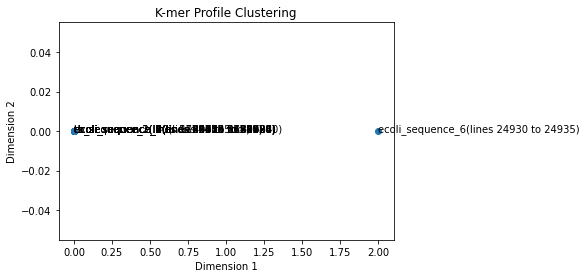

Cluster 0:
 - Sequence ID: ecoli_sequence_4(lines 25923 to 25928)
 - Sequence ID: ecoli_sequence_6(lines 24930 to 24935)
 - Sequence ID: ecoli_sequence_10(lines 26535 to 26540)
 - Sequence ID: ecoli_sequence_5(lines 48153 to 48158)
 - Sequence ID: ecoli_sequence_8(lines 60722 to 60727)
 - Sequence ID: ecoli_sequence_7(lines 55401 to 55406)
 - Sequence ID: ecoli_sequence_1(lines 30819 to 30824)
 - Sequence ID: ecoli_sequence_3(lines 31075 to 31080)
 - Sequence ID: tb_sequence_2(lines 51793 to 51798)
 - Sequence ID: tb_sequence_1(lines 17944 to 17949)
 - Sequence ID: ecoli_sequence_9(lines 843 to 848)
 - Sequence ID: tb_sequence_3(lines 26734 to 26739)
Cluster 1:
 - Sequence ID: ecoli_sequence_2(lines 39781 to 39786)


In [142]:
# Generate all possible k-mers
k_size = 6
all_kmers = generate_all_kmers(k_size)

# Generate k-mer profiles for all sequences
kmer_profiles = [generate_kmer_profile(seq, all_kmers) for seq in sequences.values()]
labels = cluster_sequences(kmer_profiles, sequence_ids ,k_size=6)

## Parsing and Processing PhylOligo Results

### Getting cluster sequences from distance matrix produced by PhylOligo

[0 1 1 1 1 0 1 0 1 1 1 1 1]
['ecoli_sequence_4(lines 25923 to 25928)', 'ecoli_sequence_6(lines 24930 to 24935)', 'ecoli_sequence_10(lines 26535 to 26540)', 'ecoli_sequence_5(lines 48153 to 48158)', 'ecoli_sequence_8(lines 60722 to 60727)', 'ecoli_sequence_2(lines 39781 to 39786)', 'ecoli_sequence_7(lines 55401 to 55406)', 'ecoli_sequence_1(lines 30819 to 30824)', 'ecoli_sequence_3(lines 31075 to 31080)', 'tb_sequence_2(lines 51793 to 51798)', 'tb_sequence_1(lines 17944 to 17949)', 'ecoli_sequence_9(lines 843 to 848)', 'tb_sequence_3(lines 26734 to 26739)']


/Users/rishika/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/rishika/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


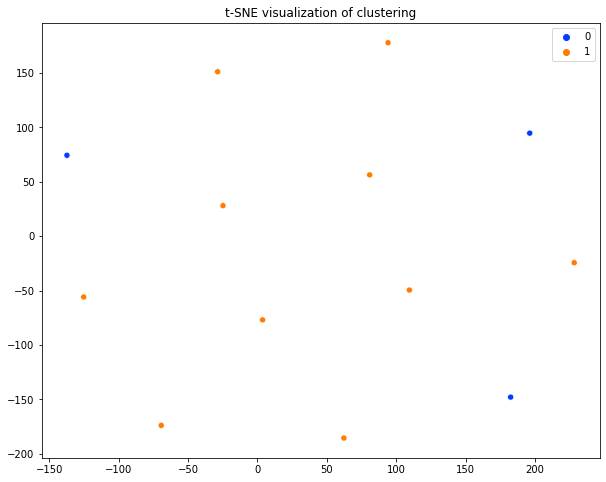

In [143]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 

# Load the distance matrix
#COMMENT OUT
phyloligo_file = 'ecoli_10_tb_3_phyloligo.txt'
#########
distance_matrix = np.loadtxt(phyloligo_file)

# Perform clustering
clusterer = KMeans(n_clusters=2)  
cluster_labels = clusterer.fit_predict(distance_matrix)
print(cluster_labels)
print(sequence_ids)

# Perform t-SNE for visualization
perplexity_value = min(30, len(sequences) - 1)
tsne = TSNE(metric = "precomputed", random_state=42, perplexity = perplexity_value)
embedded = tsne.fit_transform(distance_matrix)

# Plot t-SNE results with cluster labels
plt.figure(figsize=(10, 8))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1], hue=cluster_labels, palette='bright')
plt.title('t-SNE visualization of clustering')
plt.show()

In [144]:
cluster_counts = Counter(cluster_labels)

# Determine the most common cluster (the cluster with the highest count)
most_common_cluster = cluster_counts.most_common(1)[0][0]
print(cluster_labels)

# Identify potential contaminants
# These are sequences whose cluster label is not the most common cluster label
phyloligo_contaminants = [sequence_ids[i] for i, cluster in enumerate(cluster_labels) if cluster != most_common_cluster]
print(phyloligo_contaminants)

[0 1 1 1 1 0 1 0 1 1 1 1 1]
['ecoli_sequence_4(lines 25923 to 25928)', 'ecoli_sequence_2(lines 39781 to 39786)', 'ecoli_sequence_1(lines 30819 to 30824)']


## Intersection and Analysis from Results of both Algorithms

### Identifying the contaminants found from both methods- these are the ones we are highly confident are contaminants.

In [145]:
import re

def fuzzy_match(seq1, seq2):
    # Create patterns to match whole words
    pattern1 = fr'\b{seq1}\b'
    pattern2 = fr'\b{seq2}\b'
    return re.search(pattern1, seq2) or re.search(pattern2, seq1)

# Convert the lists to sets for efficient operations
phyloligo_set = set(phyloligo_contaminants)
kraken_set = set(kraken_contaminants)

# Initialize a set to store common contaminants
common_contaminants = set()

# Iterate through each pair of sequence IDs
for p_seq in phyloligo_set:
    for k_seq in kraken_set:
        if fuzzy_match(p_seq, k_seq):
            common_contaminants.add(k_seq)

# Output the common contaminants
print(common_contaminants)


set()


PhylOligo contaminant count: 3
Kraken contaminant count: 3
P(PhylOligo|Kraken): 0.0
P(Kraken|PhylOligo): 0.0


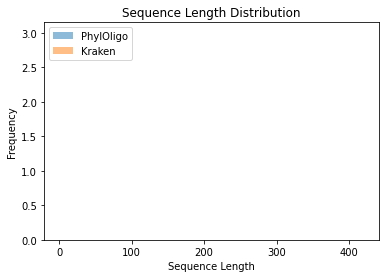

In [146]:
#Contaminant Sequence Count Analysis
phyloligo_count = len(set(phyloligo_contaminants))
kraken_count = len(set(kraken_contaminants))
print(f"PhylOligo contaminant count: {phyloligo_count}")
print(f"Kraken contaminant count: {kraken_count}")

#Probability Estimation
common_count = len(common_contaminants)
prob_phyloligo_given_kraken = common_count / kraken_count
prob_kraken_given_phyloligo = common_count / phyloligo_count
print(f"P(PhylOligo|Kraken): {prob_phyloligo_given_kraken}")
print(f"P(Kraken|PhylOligo): {prob_kraken_given_phyloligo}")

#Sequence length analysis
phyloligo_lengths = [len(sequences[seq_id]) for seq_id in phyloligo_contaminants if seq_id in sequences]
kraken_lengths = [len(sequences[seq_id]) for seq_id in kraken_contaminants if seq_id in sequences]
#Visualization
import matplotlib.pyplot as plt
# Plotting sequence length distributions
plt.hist(phyloligo_lengths, alpha=0.5, label='PhylOligo')
plt.hist(kraken_lengths, alpha=0.5, label='Kraken')
plt.legend()
plt.title('Sequence Length Distribution')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()


In [147]:
#Statistical Significance testing
from scipy.stats import chi2_contingency
# Create a contingency table
contingency_table = [[phyloligo_count, kraken_count], [len(sequences) - phyloligo_count, len(sequences) - kraken_count]]
chi2, p, dof, ex = chi2_contingency(contingency_table)
print(f"Chi-square test p-value: {p}")


Chi-square test p-value: 1.0


In [148]:
#Confidence Interval Calculation for Probability Estimations
import scipy.stats as stats
confidence = 0.95
phyloligo_interval = stats.norm.interval(confidence, loc=prob_phyloligo_given_kraken, scale=stats.sem(phyloligo_lengths))
kraken_interval = stats.norm.interval(confidence, loc=prob_kraken_given_phyloligo, scale=stats.sem(kraken_lengths))
print(f"Confidence interval for P(PhylOligo|Kraken): {phyloligo_interval}")
print(f"Confidence interval for P(Kraken|PhylOligo): {kraken_interval}")

Confidence interval for P(PhylOligo|Kraken): (nan, nan)
Confidence interval for P(Kraken|PhylOligo): (nan, nan)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2098: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:2099: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:261: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:221: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/numpy/core/_methods.py:253: RuntimeWarning: invalid val

In [149]:
output_file = '10_3_out.txt'

with open(output_file, 'w') as f:
    f.write("Kraken Identified Target Species:\n")
    f.write(f"{target_species_name}")
    f.write("Kraken Identified Potential Contaminants:\n")
    f.writelines([f"{cont}\n" for cont in kraken_contaminants])

    f.write("\nPhylOligo Identified Potential Contaminants:\n")
    f.writelines([f"{cont}\n" for cont in phyloligo_contaminants])

    f.write("\nCommon Contaminants (High Confidence):\n")
    f.writelines([f"{cont}\n" for cont in common_contaminants])

    # Additional Analyses
    f.write("\nContaminant Sequence Count Analysis:\n")
    f.write(f"PhylOligo contaminant count: {phyloligo_count}\n")
    f.write(f"Kraken contaminant count: {kraken_count}\n")

    f.write("\nProbability Estimation:\n")
    f.write(f"P(PhylOligo|Kraken): {prob_phyloligo_given_kraken}\n")
    f.write(f"P(Kraken|PhylOligo): {prob_kraken_given_phyloligo}\n")

    f.write("\nChi-Square Test for Statistical Significance:\n")
    f.write(f"Chi-square test p-value: {p}\n")

    f.write("\nConfidence Intervals for Probability Estimations:\n")
    f.write(f"Confidence interval for P(PhylOligo|Kraken): {phyloligo_interval}\n")
    f.write(f"Confidence interval for P(Kraken|PhylOligo): {kraken_interval}\n")
